# Семинар № 2
# Практика  А/В-тестов
# Дизайн А/В-теста на реальном датасете



 # Импорты и установка библиотек

In [45]:
# устанавливаем дополнительные библиотеки, которых не хватает
# mmh3 - библиотека для hash function
import sys
!{sys.executable} -m pip install mmh3


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [58]:
from tqdm.notebook import tqdm

In [46]:
import os
import datetime
import requests
import base64

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from tqdm.auto import tqdm
from zipfile import ZipFile
import matplotlib.pyplot as plt
import mmh3
import warnings
warnings.simplefilter('ignore')

# Датасет для экспериментов

1. Скачиваем датасет

In [7]:
# download dataset by chunks
url = "https://github.com/sharthZ23/your-second-recsys/raw/master/data_kion.zip"

req = requests.get(url, stream=True)

# файл скачивается и будет называться data_kion.zip (это архив)
with open('data_kion.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download: 100%|█████████████▉| 78.6M/78.8M [00:22<00:00, 3.22MiB/s]

2. Распаковываем архив из 3 файлов

In [8]:
!unzip data_kion.zip

Archive:  data_kion.zip
   creating: /Users/michil.egorov/projects/itmo/ab_test/data_kion
  inflating: __MACOSX/._data_kion    
  inflating: data_kion/users.csv     
  inflating: __MACOSX/data_kion/._users.csv  
  inflating: data_kion/items.csv     
  inflating: __MACOSX/data_kion/._items.csv  
  inflating: data_kion/interactions_df.csv  
  inflating: __MACOSX/data_kion/._interactions_df.csv  


# 📺 Данные: датасет КИОН

https://github.com/MobileTeleSystems/RecTools/tree/main/datasets/KION

- **просмотры** фильмов и сериалов в приложении онлайн-кинотеатра KION
- данные о пользователях
- данные об айтемах (фильмы, сериалы и т.д.)

In [47]:
# просмотры фильмов и сериалов в приложении KION
interactions = pd.read_csv('data_kion/interactions_df.csv', parse_dates=["last_watch_dt"])

# данные о пользователях
users = pd.read_csv('data_kion/users.csv')

# данные об айтемах (фильмы, сериалы и т.д.)
items = pd.read_csv('data_kion/items.csv')

## Мы будем использовать ТОЛЬКО данные `interactions` = пользователь `user_id` посмотрел фильм `item_id` столько-то секунд `total_dur` в такую дату `last_watch_dt`
- с датой last_watch_dt
- длительностью просмотра total_dur
- % просмотра watched_pct

In [10]:
# смотрим одновременно первые 5 строк и последние 5 строк
pd.concat([interactions.head(5), interactions.tail()])

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0
5476246,648596,12225,2021-08-13,76,0.0
5476247,546862,9673,2021-04-13,2308,49.0
5476248,697262,15297,2021-08-20,18307,63.0
5476249,384202,16197,2021-04-19,6203,100.0
5476250,319709,4436,2021-08-15,3921,45.0


## небольшая предобработка данных

In [11]:
# переводим столбец last_watch_dt в формат datetime - так с ним удобнее работать
interactions['last_watch_dt'] = pd.to_datetime(interactions['last_watch_dt']).dt.date
# переводим столбец user_id в формат string
interactions['user_id'] = interactions['user_id'].astype(str)

print(f"Уникальных юзеров в interactions: {interactions['user_id'].nunique():_}")
print(f"Уникальных айтемов в interactions: {interactions['item_id'].nunique():_}")

Уникальных юзеров в interactions: 962_179
Уникальных айтемов в interactions: 15_706


# Берем пользователей за 1 неделю

`Так как в данных есть недельная сезонность, то длину теста и данных меньше 1 недели не будем рассматривать!`

In [12]:
# макимальная дата в датасете
# вычтем из нее 7 дней
# таким образом получим данные за 7 последних дней
max_date = interactions['last_watch_dt'].max()

In [13]:
# сохраним данные за одну (последнюю) неделю
week1 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=7)]

In [14]:
week1.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
9,203219,13582,2021-08-22,6975,100.0
22,505244,15297,2021-08-15,15991,63.0
54,200197,9335,2021-08-16,83,2.0
64,73446,14488,2021-08-19,6011,100.0
65,125519,4583,2021-08-22,3,0.0


# Начинаем придумывать Дизайн Вариант 1. Метрика + эффект + критерий

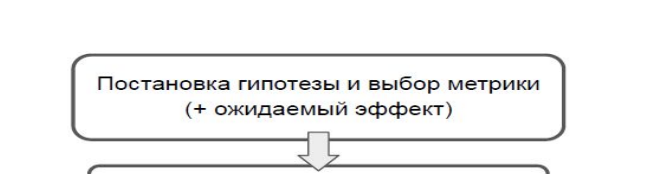

## Выбор метрики

- хотим использовать метрику "spend" = длину просмотра ДЛЯ КАЖДОГО пользователя (total_dur в датасете) - так как это основная метрика, на которую смотрит бизнес

- То есть мы хотим, чтобы после А/В-теста средняя длина просмотра на пользователя увеличилась в группе B

## Выбор эффекта

Пусть на первом этапе вместе с менеджером решили, что интересует эффект = 5% как разница между группами

### Посмотрим на распределение метрики

хотим:

- чтобы дисперсия была невысокая
- чтобы не было "выбросов" (outlier) = слишком большие или маленькие значения

In [15]:
# так как строк с просмотрами для каждого user_id несколько
# нам нужно их сложить, чтобы получить
# полную длину просмотра для каждого user_id
week1 = week1.groupby('user_id', as_index=False).agg({'total_dur': sum})

<Axes: >

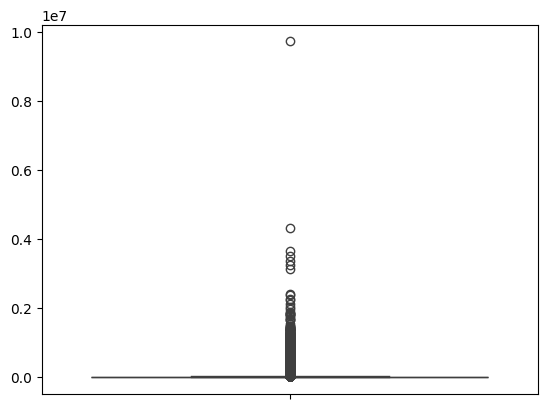

In [20]:
import seaborn as sns

# boxplot помогает увидеть выбросы
sns.boxplot(week1['total_dur'].values)

![title](https://miro.medium.com/v2/resize:fit:9000/1*2c21SkzJMf3frPXPAR_gZA.png)

In [21]:
# кажется у нас есть выброс
week1['total_dur'].max()

np.int64(9731801)

In [22]:
# кажется у нас есть выброс
week1[week1['total_dur'] == week1['total_dur'].max()]

,user_id,total_dur
128751,696597,9731801


Для удаления выбросов используем правило "3 sigma rule" - то есть что 99% значений лежат в диапазоне плюс минус 3 sigma. Значит, все что за пределами 3 sigma (std) - удаляем. Там будут и выбросы

![image](https://statisticseasily.com/wp-content/uploads/2023/04/Standard-Deviation-Rules.jpg)

In [23]:
# удалим выбросы
print(week1.shape)
upper = week1['total_dur'].mean() + 3 * week1['total_dur'].std()
week1 = week1[week1['total_dur'] <= upper]
print(week1.shape)

(185907, 2)
(184041, 2)


# Распределение метрики = гистограмма .hist()

Данные не похожи на нормальное распределение: большинство людей смотрят понемногу, распределение не симметричное.


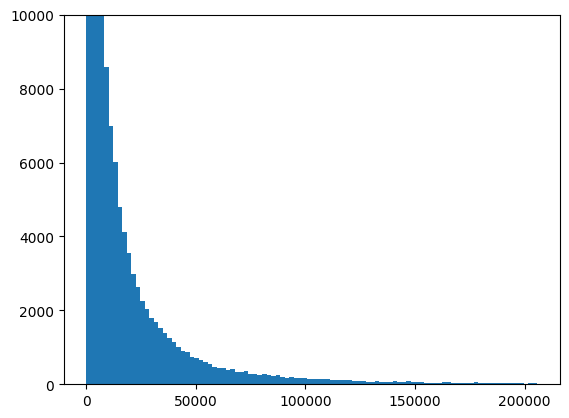

In [24]:
week1['total_dur'].hist(bins=100)
plt.ylim([0, 10000])
plt.grid(False)

## Выбор критерия

А что если использовать критерий Манна-Уитни?

- Нормальность данных не требуется
- Для него нужен ряд неповторяющихся уникальных значений (например: [23, 456, ... 67, 20])

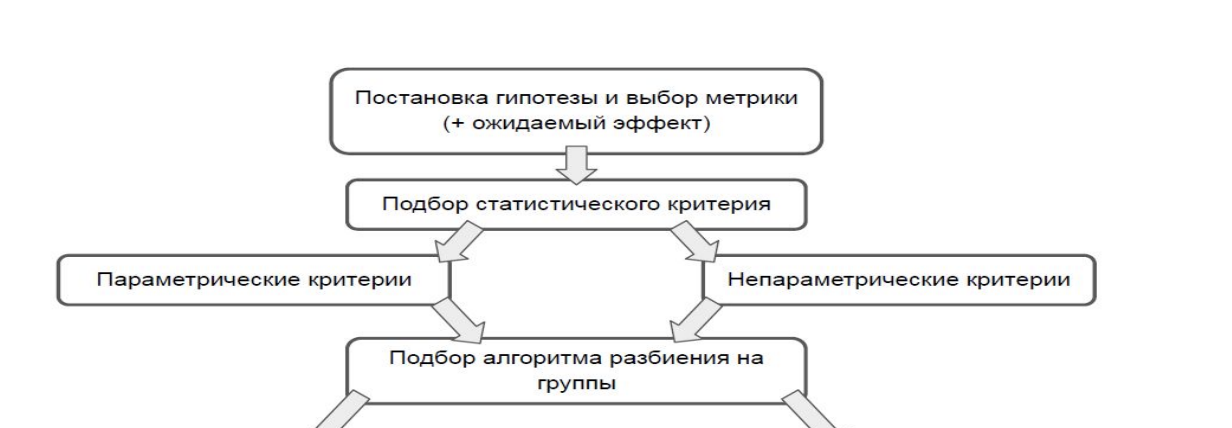

# Алгоритм разбивки на группы

- Используем хэш функцию для этого. Посчитаем хэш от айди, найдем остаток от деления на 2 (так как 2 группы - А и В) и по остатку определим к какой группе относится пользователь. То есть по айди пользователя она разобьет всех пользователей на 2 группы.

### Умеем генерировать "соль"

случайную строку, добавляемую к айдишникам при разбивке на группы по хэшу.

- В качестве неслучайного значения можно использовать номер задачи в Jira или дату.


- Не забудьте логировать (сохранять где-то) значения соли ваших экспериментов!

In [25]:
def salt_generator():
  """Func for generating random salt if user does not set salt"""
  salt = os.urandom(8)
  return base64.b64encode(salt).decode('ascii')


def get_salt(user_salt=None, save_salt=True):
  """Func for setting salt"""

  # соль задает пользователь или генерируем
  if user_salt:
      salt = user_salt
  else:
      salt = salt_generator()

  # логируем соль
  if save_salt:
      today = datetime.today().date().strftime('%Y-%m-%d')
      with open(f"salt_{today}.txt", 'w') as f:
          f.write(salt)
  return salt


In [26]:
# попробуйте запустить несколько раз и посмотрите на результат
# он каждый раз будет разный
salt_generator()

'mwoD4gXhhb4='

# Функция для разделения на группы с использованием хэш-функции

In [28]:
import mmh3

def get_hash(df, col='user_id',
             salt=None, n_groups=2,
             return_salt=False):
    """
    Делим пользователей на 2 группы по хэшу.
    """

    # генерируем соль, если она не задана
    if salt is None:
        salt = salt_generator()

    # строковое представление id + соль
    ids = df[col].astype(str) + salt

    # считаем хэш и приводим к unsigned
    hashes = ids.map(lambda x: mmh3.hash128(x) & ((1 << 128) - 1))

    groups = (hashes % n_groups).astype(int)
    groups.name = 'group'

    if return_salt:
        return groups, salt
    return groups

In [29]:
# делим пользователей на группы A и B по хэшу с использованием соли
# появится новый столбец group с номером группы (0 или 1)
week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt='seminar2')
week1.head()

,user_id,total_dur,group
0,1,1593,1
1,1000001,52,1
2,1000003,625,1
3,1000008,3691,1
4,1000009,2444,0


In [30]:
week1['group'].value_counts()

group
0    92131
1    91910
Name: count, dtype: int64

Метрику + критерий + как разбивать на группы - выбрали




## Переходим к валидации критерия: А/А-тест
- оценка распределения p_value
- оценка мощности
- корректности

**Распределения p_value** при корректном подборе пары метрика + критерий -  равномерное распределение

**Корректность** - вероятность того, что найдет различие, когда его нет

$$significance = Pr(\text{reject }H_0 | H_0 \text{ is true})$$

**Мощность** - вероятность того, что критерий найдет различие в случае, когда оно есть

$$power = Pr(\text{reject }H_0 | H_1 \text{ is true})$$

Увеличение мощности критерия ведет к уменьшению вероятности ошибки второго рода

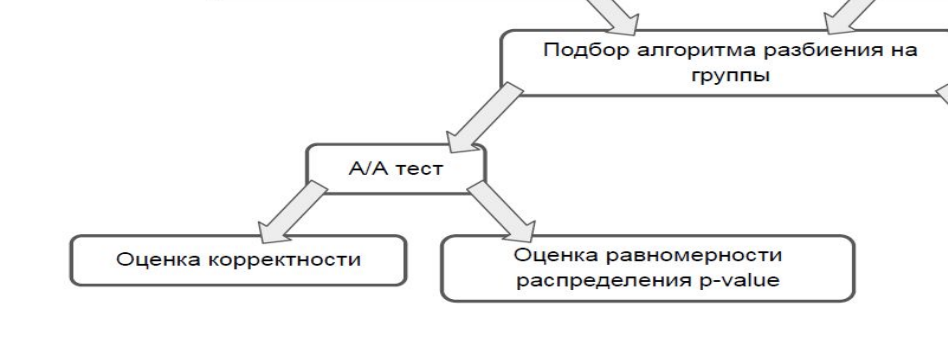

In [31]:
from scipy.stats import mannwhitneyu

# проверим, как работает код критерия Манна-Уитни
u, p = mannwhitneyu(week1[week1['group'] == 0]['total_dur'].values,
                    week1[week1['group'] == 1]['total_dur'].values)

print(f"Значение статистики = {u}, p_value = {p}")

Значение статистики = 4226678176.0, p_value = 0.5274061852699901


## Проверка распределения p_value - должно быть равномерное

In [32]:
# массив, куда будем сохранять значения p_value
pvalues = []

for i in tqdm(range(100)):  # 1000 итераций в реальности

  # каждый раз ПЕРЕразбиваем на группы
  # иначе вы получите 1000 одинаковых результатов
  week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt=None)

  u, p = mannwhitneyu(
        week1[week1['group'] == 0]['total_dur'].values, # Группа А
        week1[week1['group'] == 1]['total_dur'].values # Группа В
    )
  pvalues.append(p) # сохраняем p_value на каждой итерации


100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.06it/s]


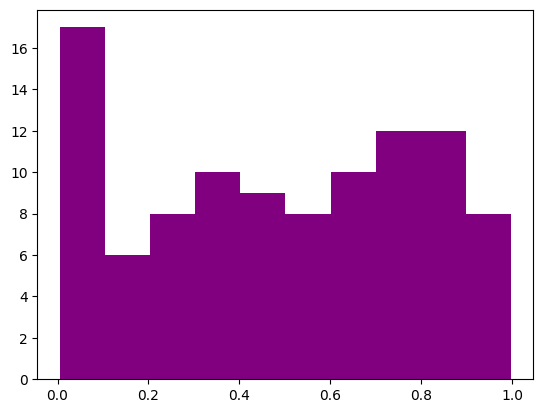

In [33]:
# смотрим распределение получившихся после АА-теста значений p_value
plt.hist(pvalues, bins=10, color='purple');

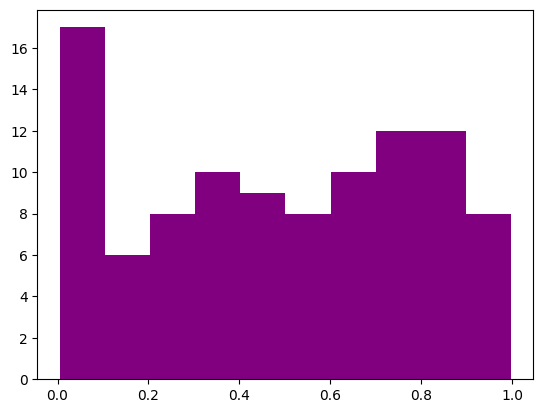

In [34]:
# смотрим распределение получившихся после АА-теста значений p_value
plt.hist(pvalues, bins=10, color='purple');

![image](https://sense23.com/wp-content/uploads/2020/06/0_QdtHcSBSHn0AmoTW.png)

## Ой. Как-то это распределение не похоже на равномерное. Кажется критерий Манна-Уитни не подходит. А почему так произошло?

In [35]:
for i in tqdm(range(10)):

  week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt=None)

  group_a = week1[week1['group'] == 0]
  group_b = week1[week1['group'] == 1]

  print(f"% уник. значений группы А = {round(group_a['total_dur'].nunique() / group_a.shape[0] * 100, 2)}%")
  print(f"% уник. значений группы B = {round(group_b['total_dur'].nunique() / group_b.shape[0] * 100, 2)}%")
  print('')



 30%|█████████████▏                              | 3/10 [00:00<00:00, 11.71it/s]

% уник. значений группы А = 34.64%
% уник. значений группы B = 34.47%

% уник. значений группы А = 34.57%
% уник. значений группы B = 34.42%

% уник. значений группы А = 34.54%
% уник. значений группы B = 34.48%

% уник. значений группы А = 34.52%
% уник. значений группы B = 34.57%

% уник. значений группы А = 34.52%
% уник. значений группы B = 34.5%




100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 15.84it/s]

% уник. значений группы А = 34.53%
% уник. значений группы B = 34.43%

% уник. значений группы А = 34.55%
% уник. значений группы B = 34.48%

% уник. значений группы А = 34.64%
% уник. значений группы B = 34.42%

% уник. значений группы А = 34.57%
% уник. значений группы B = 34.42%

% уник. значений группы А = 34.38%
% уник. значений группы B = 34.71%



# Вывод по варианту дизайна 1

Этот вариант не подходит, учитывая график p_value

Кажется мы все-таки нарушили область применимости критерия - значения длины просмотра на пользователя не настолько уникальны, как нам показалось сначала. Что ж - это реальные данные.

Но так как мы следовали четко по алгоритму дизайна, ошибку удалось обнаружить достаточно рано.


# Вариант дизайна 2. Подбираем другой критерий



## Выбор метрики: длина просмотра на пользователя

- оставляем ту же метрику "spend" = длину просмотра на пользователя (total_dur в датасете)


## Пробуем другой критерий - **бутстрап (bootstrap)**

![image](https://miro.medium.com/v2/resize:fit:1400/1*CJfF85VtjFvNhjSyZT4thw.png)

### `Как работает (теория)`

- Для каждой группы A и B m раз генерируются выборки из
исходной выборки (как выборки с возвращением)

- На каждой паре псевдовыборок считается некоторая
статистика (например, mean), которую мы хотим оценить

- Дальше строим 95% доверительный интервал для распределения
статистик (так как зафиксировали альфа = 0.05)

- Считаем квантили для этого доверительного интервала

- Смотрим, где лежит наша статистика в этом распределении

### `Как реализуем на практике`

Реализуем цикл (рекомендация - повторение не менее 1000 раз), на каждом шаге которого:

- создаем выборку с возвращением отдельно для группы А, группы В

- считаем среднее (mean) для группы А, группы В

- считаем разницу mean A - mean B

- сохраняем каждую разницу в массив

- после окончания цикла для массива из mean считаем квантили распределения (то есть это будет интервал)

- далее будем смотреть, вошел ли 0 в этот интервал (то есть оцениваем, mean A - mean B меньше или больше 0)


In [36]:
def bootstrap_mean_diff_ci(group_a, group_b, alpha=0.05,
                           iters=1000, return_distribution=False):
    values = []
    for _ in range(iters):
        values.append(
            # np.random.choice создает выборку с возвращением при replace=True
            # сразу считаем mean A - mean B
            np.random.choice(group_a, replace=True, size=len(group_a)).mean()
            -
            np.random.choice(group_b, replace=True, size=len(group_b)).mean()
        )

    if return_distribution:
         # возвращаем сами значения массива и квантили распределения
        return values, np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)]) # [1.05; 2.35]
    else:
        # возвращаем квантили распределения
        return np.percentile(values, [100 * alpha / 2., 100 * (1 - alpha / 2.)])




## Опять проверяем корректноcть (significance) и распределение p_value с помощью АА

Моделируем AA-test: прогоняем бутстрап критерий, не добавляя эффект к группе В. Хотим, чтобы критерий НЕ нашел различий в выборках. Если точнее, то нашел не более чем  $\alpha$ случаях.

### Вимание! Бутстреп считается достаточно долго, особенно если вы поставите кол-во итераций = 1000 `iters=1000`

Можно сделать `iters=100` для демонстрации работы




In [37]:
N = 100  # кол-во циклов для АА
significance_list = []
value_list = []

for i in tqdm(range(N)):  # кол-во циклов для АА

  week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt=None)

  group_a = week1[week1['group'] == 0]['total_dur'].values
  group_b = week1[week1['group'] == 1]['total_dur'].values

  values, (left_side, right_side) = bootstrap_mean_diff_ci(
      group_a,
      group_b,
      iters=1000,  # кол-во циклов сэмплирования для бутстреп критерия
      return_distribution=True
  )

  significance_list.append(not left_side <= 0 <= right_side)
  value_list.append(values)



100%|█████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


## Так как критерий bootstrap мы написали сами, с нуля, то и считать p_value нам придется самим.

Напишем функцию для этого

In [38]:
# посчитаем значения p_value по определению p_value = P(TS | H_0 is true)
# передадим в get_p_value разницы средних от бутстрапа

def get_p_value(dist):
    dist = np.asarray(dist)

    # эмпирически проверяем насколько часто dist с разных сторон от нуля
    p_right = (dist >= 0).mean()
    p_left  = (dist <= 0).mean()

    # двухсторонний p-value - минимальная хвостовая вероятность
    return 2 * min(p_right, p_left)


In [39]:
p_values = [get_p_value(values) for values in value_list]

Text(0.5, 1.0, 'Бутстреп распределение p_value\nsignificance = 0.07')

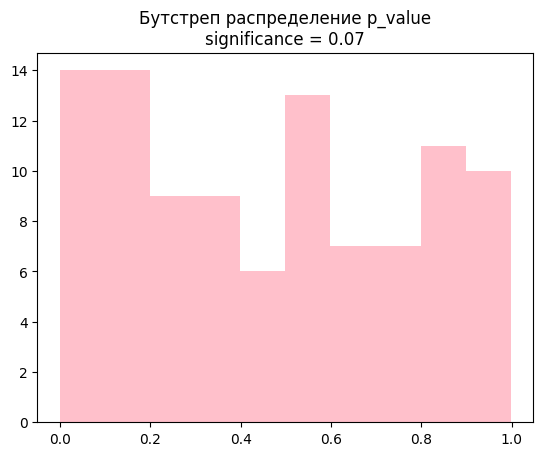

In [40]:
plt.hist(p_values, bins=10, color='pink');
plt.title(f"Бутстреп распределение p_value\nsignificance = {np.round(np.mean(significance_list), 2)}")

Давайте еще проверим критерием Колмогорова-Смирнова (о том, что получившееся распределение p_values есть равномерное распределение). Здесь нужно держать в уме, что критерий не очень мощный (помним, что мощный от 80% случаев найденных различий)

In [41]:
import scipy.stats

stat, p_value = scipy.stats.kstest(p_values, scipy.stats.uniform(loc=0.0, scale=1.0).cdf)

if p_value < 0.05:
  print(f'p_value = {p_value} -> p_values неравномерное распределение')
else:
  print(f'p_value = {p_value} -> p_values равномерное распределение')

p_value = 0.2961216072789328 -> p_values равномерное распределение


# Мощность

Будем добавлять эффект в виде умножения значений в группе B на (1 + effect)


## Код цикла для подсчета мощности

В зависимости от размера эффекта (картинка справа)

In [42]:
N = 100  # кол-во итераций "псевдо-АВ" для мощности
effect_list = [0.01, 0.03, 0.05]  # [1%, 3%, 5%]

power_and_effect = []

for effect in effect_list:

    power = []

    for i in tqdm(range(N)):

        # новый сплит по хэшу на каждой итерации
        week1['group'] = get_hash(week1, col='user_id', n_groups=2, salt=None)

        group_a = week1[week1['group'] == 0]['total_dur'].values
        group_b = week1[week1['group'] == 1]['total_dur'].values

        left_side, right_side = bootstrap_mean_diff_ci(
            group_a,
            group_b * (1 + effect), # добавляем эффект к группе B
            iters=100,
            return_distribution=False
        )

        power.append(not (left_side <= 0 <= right_side))

    # сохраняем эффект + вектор мощности
    power_and_effect.append({
        "effect": effect,
        "power": power
    })


100%|█████████████████████████████████████████| 100/100 [00:15<00:00,  6.28it/s]

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.23it/s]

100%|█████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


In [43]:
def plot_power(power_list, color='pink', title='', verbose=True):
    """
    Строит график мощности по списку power_dict'ов
    {"effect": float, "power": list_of_bools}
    """

    # достаём эффекты и средние значения мощности
    x = [d["effect"] for d in power_list]
    y = [np.mean(d["power"]) for d in power_list]

    # печать статистики
    if verbose:
        for effect, power in zip(x, y):
            print(f"вероятность, что бутстрап найдет отличие в {effect * 100:.0f}% = "
                  f"{power:.2f}")

    fig, ax = plt.subplots(1, 1)
    ax.plot(x, y, marker='o', color=color)

    ax.set_xticks(x)
    ax.set_xticklabels([f"{effect}" for effect in x])
    ax.grid(False)
    ax.set_ylim([0, 1.1])
    plt.title(title)

    return fig, ax

Нас интересует мощность >= 0.8

То есть это значит, что критерий находит различие там, где оно ЕСТЬ, в 80% случаях

вероятность, что бутстрап найдет отличие в 1% = 0.24
вероятность, что бутстрап найдет отличие в 3% = 0.93
вероятность, что бутстрап найдет отличие в 5% = 1.00


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Power depends on effect'}>)

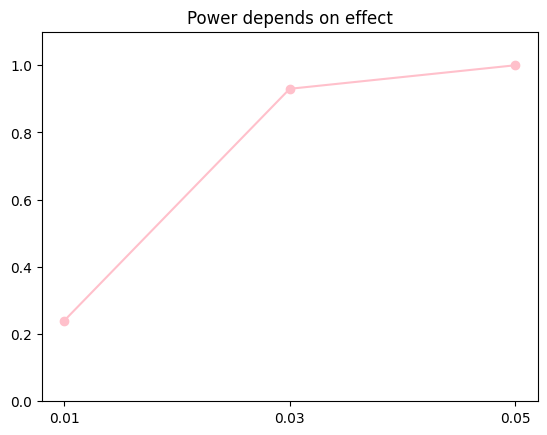

In [44]:
plot_power(power_list=power_and_effect, title='Power depends on effect')

Видим, что мощность больше 0.8 достигается когда мы будем пытаться обнаружить разницу между группами ближе к 3%. Это довольно большой эффект, который **возможно будет сложно обнаружить в РЕАЛЬНОМ эксперименте**.

Это значит, что  следующим шагом надо будет провести эксперименты с размером выборки! Для того, чтобы попробовать обнаружить **меньший  эффект на более большой выборке** (*так как чем больше выборка, тем меньший эффект мы возможно сможем обнаружить*).

Поэтому домашнее задание:

# Домашнее задание. Зависимость мощности от размера выборки. Построение графика и выводов по нему. `Максимум 50 баллов`

`! Сумма баллов за все пункты больше 50. Это значит, что вы можете сделать НЕ ВСЕ пункты и все равно получить максимальную оценку. Получение больше 50 баллов приравнивается к 50 и не переходит на другие домашние задания. `


1) Получите данные по просмотру на каждого пользователя за интервал в 2 недели и за интервал в 3 недели. Очистите от выбросов.

- `по 5 баллов, итого 10 баллов максимум за весь пункт 1`

2) Зафиксируйте размер эффекта (строго менее 3%, как мы получили на последнем графике в семинаре). Посчитайте мощность для интервала в 1, 2 и 3 недели для зафиксированного вами эффекта и критерия бутстреп.

<font color='red'>*Внимание, не нужно делать AA-тест и проверки на его основе! Только посчитать мощность в зависимости от размера выборки*</font>

- для `N=100` итераций АА-теста и `iters=100` итераций сэмплирования для бутстреп критерия - `максимум 10 баллов`
- для `N=100` итераций АА-теста и `iters=1000` итераций сэмплирования для бутстреп критерия - `максимум 20 баллов`
- для `N=1000` итераций АА-теста и `iters=1000` итераций сэмплирования для бутстреп критерия - `максимум 30 баллов`

3) Нарисуйте график зависимости мощности от размера выборки с зафиксированным эффектом (за 1 неделю, 2 недели, 3 недели). `Максимум - 10 баллов` = график и правильно распечатанный размер выборки для каждой точки

- По оси Х должны быть отложены размеры выборки за 1, 2 и 3 недели. По оси У - мощность. Должно получиться 3 точки на графике.

4) Сделайте вывод, какой размер выборки вы бы выбрали для А/В теста и какой длины тест будет. `Максимум - 10 баллов`

In [51]:
import sys
import subprocess
import multiprocessing as mp

from dataclasses import dataclass
from joblib import Parallel, delayed
from typing import List, Tuple, Optional


@dataclass
class BootstrapConfig:
    alpha: float = 0.05
    iters: int = 1000
    n_jobs: int = -1
    
    def __post_init__(self):
        if self.n_jobs == -1:
            self.n_jobs = mp.cpu_count()
        else:
            self.n_jobs = max(1, min(self.n_jobs, mp.cpu_count()))


@dataclass
class PowerAnalysisConfig:
    effect: float = 0.02
    n_iterations: int = 1000
    bootstrap_config: BootstrapConfig = None
    
    def __post_init__(self):
        if self.bootstrap_config is None:
            self.bootstrap_config = BootstrapConfig()
        if self.effect >= 0.03:
            raise ValueError("Эффект должен быть строго менее 3% (< 0.03)")


@dataclass
class PowerResult:
    sample_size: int
    power: float
    weeks: int


print(f"Доступно ядер CPU: {mp.cpu_count()}")

Доступно ядер CPU: 10


In [52]:
def _single_bootstrap_iteration(group_a: np.ndarray, group_b: np.ndarray) -> float:
    return (
        np.random.choice(group_a, replace=True, size=len(group_a)).mean()
        - np.random.choice(group_b, replace=True, size=len(group_b)).mean()
    )


def bootstrap_mean_diff_ci_parallel(
    group_a: np.ndarray, 
    group_b: np.ndarray, 
    config: BootstrapConfig = None,
    return_distribution: bool = False
) -> Tuple[float, float]:
    if config is None:
        config = BootstrapConfig()
    
    # Параллельный расчет bootstrap итераций
    values = Parallel(n_jobs=config.n_jobs)(
        delayed(_single_bootstrap_iteration)(group_a, group_b)
        for _ in range(config.iters)
    )
    
    values = np.array(values)
    quantiles = np.percentile(values, [100 * config.alpha / 2., 100 * (1 - config.alpha / 2.)])
    
    if return_distribution:
        return values, quantiles
    else:
        return quantiles[0], quantiles[1]


def split_into_groups(
    data: pd.DataFrame, 
    user_col: str = 'user_id',
    n_groups: int = 2,
    salt: Optional[str] = None
) -> Tuple[np.ndarray, np.ndarray]:
    data_copy = data.copy()
    data_copy['group'] = get_hash(data_copy, col=user_col, n_groups=n_groups, salt=salt)
    
    group_a = data_copy[data_copy['group'] == 0]['total_dur'].values
    group_b = data_copy[data_copy['group'] == 1]['total_dur'].values
    
    return group_a, group_b


def apply_effect(group_b: np.ndarray, effect: float) -> np.ndarray:
    return group_b * (1 + effect)


def check_effect_detected(left_side: float, right_side: float) -> bool:
    return not (left_side <= 0 <= right_side)

In [62]:
def calculate_power(
    week_data: pd.DataFrame,
    config: PowerAnalysisConfig = None,
    weeks: int = 1,
) -> PowerResult:
    if config is None:
        config = PowerAnalysisConfig()
    
    sample_size = len(week_data)

    for i in range(config.n_iterations):
        # Разделяем на группы
        group_a, group_b = split_into_groups(week_data, salt=None)
        
        # Применяем эффект
        group_b_with_effect = apply_effect(group_b, config.effect)
        
        # Применяем параллелизованный bootstrap
        left_side, right_side = bootstrap_mean_diff_ci_parallel(
            group_a,
            group_b_with_effect,
            config=config.bootstrap_config
        )
        
        # Проверяем, найден ли эффект
        effect_found = check_effect_detected(left_side, right_side)
        power_results.append(effect_found)
    
    power = np.mean(power_results)
    
    return PowerResult(
        sample_size=sample_size,
        power=power,
        weeks=weeks
    )


def calculate_power_for_weeks(
    week_data_list: List[pd.DataFrame],
    weeks_list: List[int],
    config: PowerAnalysisConfig = None,
) -> List[PowerResult]:
    if config is None:
        config = PowerAnalysisConfig()
    
    results = []
    for week_data, weeks in zip(week_data_list, weeks_list):
        result = calculate_power(week_data, config, weeks=weeks)
        results.append(result)
    
    return results

In [63]:
# Пункт 1: Подготовка данных


# Правило 3 сигма
def remove_outliers(df, column='total_dur'):
    upper = df[column].mean() + 3 * df[column].std()
    return df[df[column] <= upper]

max_date = interactions['last_watch_dt'].max()

# Данные за 2 недели
week2 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=14)]
week2 = week2.groupby('user_id', as_index=False).agg({'total_dur': sum})

# Данные за 3 недели  
week3 = interactions[interactions['last_watch_dt'] >= max_date - datetime.timedelta(days=21)]
week3 = week3.groupby('user_id', as_index=False).agg({'total_dur': sum})

week1_clean = remove_outliers(week1)
week2_clean = remove_outliers(week2) 
week3_clean = remove_outliers(week3)

print(f"Размеры выборок после очистки:")
print(f"1 неделя: {len(week1_clean):,} пользователей")
print(f"2 недели: {len(week2_clean):,} пользователей") 
print(f"3 недели: {len(week3_clean):,} пользователей")

Размеры выборок после очистки:
1 неделя: 179,255 пользователей
2 недели: 276,067 пользователей
3 недели: 351,837 пользователей


In [64]:
# Пункт 2: Подсчет мощности

config = PowerAnalysisConfig(
    effect=0.02,
    n_iterations=1000,
    bootstrap_config=BootstrapConfig(
        iters=1000, 
        n_jobs=-1 
    )
)

print("Расчет мощности...")

results = calculate_power_for_weeks(
    week_data_list=[week1_clean, week2_clean, week3_clean],
    weeks_list=[1, 2, 3],
    config=config,
    parallel_outer=False
)

power_week1 = results[0].power
power_week2 = results[1].power
power_week3 = results[2].power

print()
print(f"Мощность критерия:")
print(f"1 неделя ({results[0].sample_size:,} пользователей): {power_week1:.3f}")
print(f"2 недели ({results[1].sample_size:,} пользователей): {power_week2:.3f}")
print(f"3 недели ({results[2].sample_size:,} пользователей): {power_week3:.3f}")

power_results = results

Расчет мощности...
Эффект: 2.0%
Количество итераций А/В теста: 1000
Количество итераций бутстрапа: 1000
Параллельных процессов для bootstrap: 10


Мощность критерия:
1 неделя (179,255 пользователей): 0.813
2 недели (276,067 пользователей): 0.850
3 недели (351,837 пользователей): 0.794


Размеры выборок:
1 неделя: 179,255 пользователей
2 неделя: 276,067 пользователей
3 неделя: 351,837 пользователей


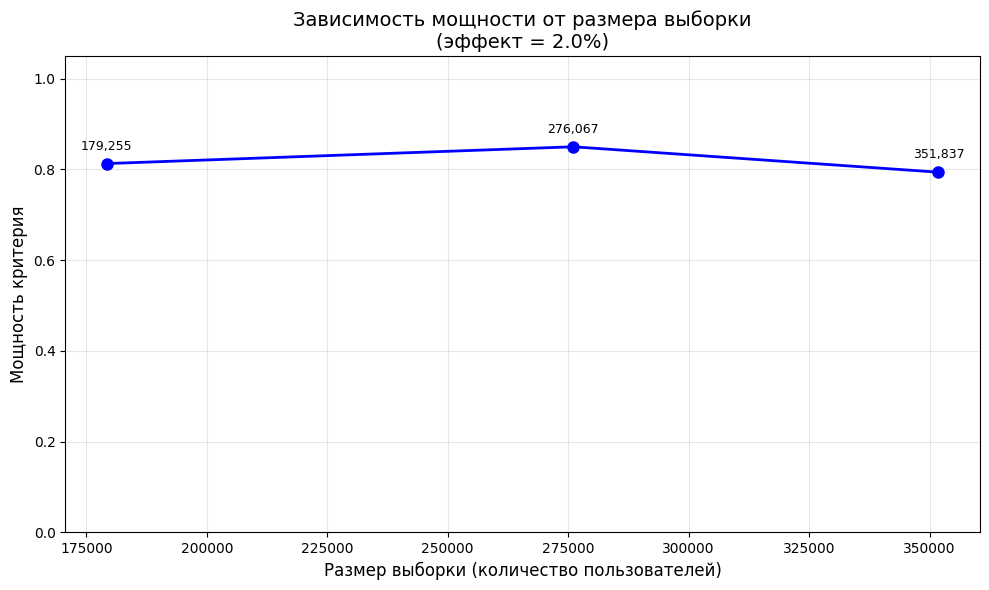

In [65]:
# Пункт 3: График зависимости мощности от размера выборки

sample_sizes = [r.sample_size for r in power_results]
powers = [r.power for r in power_results]
weeks_list = [r.weeks for r in power_results]
effect_value = config.effect

print("Размеры выборок:")
for weeks, size in zip(weeks_list, sample_sizes):
    print(f"{weeks} неделя: {size:,} пользователей")

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, powers, 'o-', linewidth=2, markersize=8, color='blue')
plt.xlabel('Размер выборки (количество пользователей)', fontsize=12)
plt.ylabel('Мощность критерия', fontsize=12)
plt.title(f'Зависимость мощности от размера выборки\n(эффект = {effect_value*100:.1f}%)', fontsize=14)
plt.grid(True, alpha=0.3)

for i, (size, power) in enumerate(zip(sample_sizes, powers)):
    plt.annotate(f'{size:,}', (size, power), textcoords="offset points", 
                 xytext=(0,10), ha='center', fontsize=9)

plt.ylim(0, 1.05)
plt.tight_layout()
plt.show()

ВЫВОДЫ И РЕКОМЕНДАЦИИ ДЛЯ A/B ТЕСТА
----

1. Текущий анализ проведен для эффекта 2.0%
2. Мощность критерия достигает максимума мощности 85% при:
   - 2 недели данных (276,067 пользователей) - мощность 85%
3. Рекомендации:
   - Использовать данные за 2 недели
   - Размер выборки: 276,067 пользователей
   - Длительность теста: 2 недели
4. Зависимость мощности от размера выборки:
   - 1 неделя (179,255 пользователей): мощность 81.3%
   - 2 неделя (276,067 пользователей): мощность 85.0%
   - 3 неделя (351,837 пользователей): мощность 79.4%